# Predicting NFL player stats with an LSTM neural network

## Introduction

There's a bit too much code and output here to format a nice article, so I'll just link to some key sections after summarizing the project here.

This project aims to use an LSTM neural network implemented in TensorFlow to predict individual player box scores in future NFL games. The dataset comes from scraping pro-football-reference.com; my code for scraping and parsing the data can be found [on github](https://github.com/ewelchman/scrape_pfr). I use stats from 2013-2016 for training, and 2017-2018 for testing and validation. The model is a two-layer LSTM cell. I transform the data with a scaling function prior to feeding the model, and use a mean-squared error cost function with a little bit of L2 regularization to help prevent overfitting, with the Adam optimizer. I do this with two different scalers and show that the results differ wildly.

Finally, I transform output back to recognizable data in order to visually compare predictions with reality.

## Contents

* [Introduction](#Introduction)
* [Make input batches](#Set-up-batches-for-data-input)
* [Test-train data split](#Split-data-into-training-and-testing-sets)
* [Define model parameters](#Define-model-parameters)
* [Train the model](#Model-training)
* [View model predictions](#View-model-predictions)
* [Commentary](#Commentary)

In [1]:
import pandas as pd
import numpy as np
import copy
import random
import tensorflow as tf
import os
import json

/home/welced12/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Looking at the raw data

In [3]:
stat_cols = [
    'pass_att','pass_cmp','pass_yds','pass_long','pass_td','pass_int',
    'pass_sacked','pass_rating','rush_att','rush_yds','rush_td','rush_long',
    'fumbles','fumbles_lost','targets','rec','rec_yds','rec_td','rec_long'
]
rbwr_stat_cols = [
    'rush_att','rush_yds','rush_td','fumbles_lost','targets','rec',
    'rec_yds','rec_td','snaps_off_pct','inj_playrate'
]
info_cols = ['player_a','pos','team','season','week']

rawstats = {}
for year in range(2013,2019):
    fname = '/home/welced12/git/scrape_pfr/data/parsed_files/parsed_stats/{}.csv'.format(year)
    df = pd.read_csv(fname)
    rawstats[year] = df
    
rawstats[2017].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14626 entries, 0 to 14625
Data columns (total 34 columns):
season           14626 non-null int64
week             14626 non-null int64
gid              9286 non-null object
team             14626 non-null object
player_href      14626 non-null object
player_a         14626 non-null object
pos              14626 non-null object
pass_att         10402 non-null float64
pass_cmp         10402 non-null float64
pass_yds         10402 non-null float64
pass_long        10402 non-null float64
pass_td          10402 non-null float64
pass_int         10402 non-null float64
pass_sacked      10402 non-null float64
pass_rating      10402 non-null float64
rush_att         10402 non-null float64
rush_yds         10402 non-null float64
rush_td          10402 non-null float64
rush_long        10402 non-null float64
fumbles          10402 non-null float64
fumbles_lost     10402 non-null float64
targets          10402 non-null float64
rec              1040

In [4]:
playerstats[
    playerstats.player_a == 'Curtis Samuel'
][info_cols+rbwr_stat_cols].sort_values(by=['week'])

,player_a,pos,team,season,week,rush_att,rush_yds,rush_td,fumbles_lost,targets,rec,rec_yds,rec_td,snaps_off_pct,inj_playrate
11410,Curtis Samuel,WR,CAR,2018,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
11419,Curtis Samuel,WR,CAR,2018,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
11420,Curtis Samuel,WR,CAR,2018,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
11421,Curtis Samuel,WR,CAR,2018,5,0.0,0.0,0.0,0.0,4.0,2.0,37.0,1.0,0.17,NaN
11422,Curtis Samuel,WR,CAR,2018,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN
11423,Curtis Samuel,WR,CAR,2018,7,2.0,9.0,1.0,0.0,1.0,1.0,16.0,0.0,0.32,NaN
11424,Curtis Samuel,WR,CAR,2018,8,0.0,0.0,0.0,0.0,3.0,3.0,28.0,0.0,0.40,NaN
11425,Curtis Samuel,WR,CAR,2018,9,1.0,33.0,1.0,0.0,4.0,2.0,25.0,1.0,0.27,NaN
11411,Curtis Samuel,WR,CAR,2018,10,1.0,1.0,0.0,1.0,4.0,4.0,18.0,0.0,0.33,NaN
11412,Curtis Samuel,WR,CAR,2018,11,0.0,0.0,0.0,0.0,7.0,5.0,55.0,1.0,0.28,NaN


## Set up batches for data input

In [5]:
def make_batches(df, scaler=None):
    ### Parameters for inputs
    hist_length = 8  # Time periods of hist sequence used for model - 8 weeks
    f_horizon = 1    # Future periods to predict
    x_batches = []   # List in which to store individual input batches
    y_batches = []   # Same, but for outputs
    pred_info = []   # List for context of batches
    
    # Fill empty cells with appropriate values. 0 for stats, 1 for playrate
    possible_stat_cols = [
        'pass_att','pass_cmp','pass_yds','pass_long','pass_td','pass_int',
        'pass_sacked','pass_rating','rush_att','rush_yds','rush_td','rush_long',
        'fumbles','fumbles_lost','targets','rec','rec_yds','rec_td','rec_long',
        'snaps_off_pct'
    ]
    present_stat_cols = [x for x in possible_stat_cols if x in df.columns]
    df[present_stat_cols] = df[present_stat_cols].fillna(0)
    df['inj_playrate'] = df['inj_playrate'].fillna(1)
    
    if scaler != None:
        frames = []
        
    # Isolate stats for each player
    for name in df['player_href'].unique():
        
        # Sort chronologically
        plyr_df = df[ df['player_href'] == name ].sort_values(by=['season','week'])
        
        # shift playrate column up 1 so that injury designation can be used as input
        plyr_df.inj_playrate = plyr_df.inj_playrate.shift(-1).fillna(0)
        
        # Transform stats with scaler above, if it's specified
        if scaler != None:
            plyr_df[rbwr_stat_cols] = scaler.transform(plyr_df[rbwr_stat_cols])
            frames.append(plyr_df)
        
        # Make a batch for each set of hist_length + f_horizon consecutive games
        array = np.array(plyr_df[rbwr_stat_cols])
        context = plyr_df[info_cols].values
        for i in range(len(array)):
            if i + hist_length + f_horizon > len(array):
                break
            x_batch = array[i:i+hist_length]
            y_batch = array[i+hist_length:i+hist_length+f_horizon,:-1]
            x_batches.append(x_batch)
            y_batches.append(y_batch[0])
            pred_info.append(context[i+hist_length:i+hist_length+f_horizon])
            
        # Save player/week/season information to match with predictions later
        
            
    out = {
        'x_batches': x_batches,
        'y_batches': y_batches,
        'raw_df': df[info_cols+rbwr_stat_cols],
        'pred_info': pred_info
    }
    
    if scaler != None:
        out['scaled_df'] = pd.concat(frames, sort=False
                           ).sort_values(by=['player_href','season','week']
                           )[info_cols+rbwr_stat_cols]
                    
    return out

## Split data into training and testing sets

In [6]:
def rbwr_filter(df):
    rbwr_filter = [
        True if str(p) in ['RB','FB','WR','TE']
        else False for p in df['pos'].values
    ]
    return df[rbwr_filter]


# Train on 2013-2016
train_set = rbwr_filter(
                pd.concat([rawstats[yr] for yr in range(2013,2017)], sort=False)
)
train_data = make_batches(train_set)
# Test on 2017-2018
test_set = rbwr_filter(
                pd.concat([rawstats[yr] for yr in range(2017,2019)], sort=False)
)
test_data = make_batches(test_set)

print(train_data['x_batches'][-2:])
print(train_data['y_batches'][-2:])

[array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 2.    ,  5.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.07  ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  3.    ,  1.    , 19.    ,
         0.    ,  0.17  ,  0.4545],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.02  ,  1.    ]]), array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,

## Make Scaler to normalize stat values

So that columns have similar effects on cost functions

In [7]:
from sklearn import preprocessing

# Create a quantile transformer and use the training set to parameterize it
qt = preprocessing.QuantileTransformer(output_distribution='normal', 
                                       random_state=0)
fitted_qt = qt.fit(train_data['raw_df'][rbwr_stat_cols])

# Create scaled datasets
scaled_train_data = make_batches(train_set, scaler=fitted_qt)
scaled_test_data = make_batches(test_set, scaler=fitted_qt)
print(train_data['x_batches'][-1:])
print(scaled_train_data['x_batches'][-1:])

[array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 2.    ,  5.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.07  ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  3.    ,  1.    , 19.    ,
         0.    ,  0.17  ,  0.4545],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.02  ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.06  ,  1.    ]])]
[array([[-5.19933758, -0.20978711, -5.19933758, -5.19933758, -5.19933758,
        -5.19933758, -0.57459451, -5.19933758, -5.19933758,  5.1993

/home/welced12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


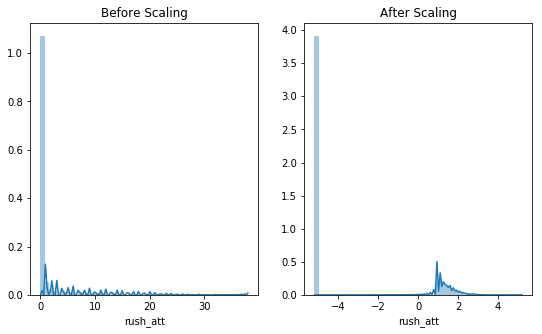

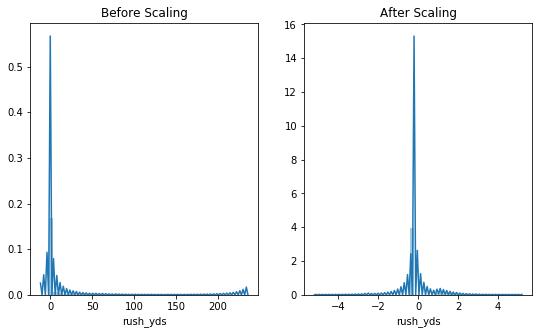

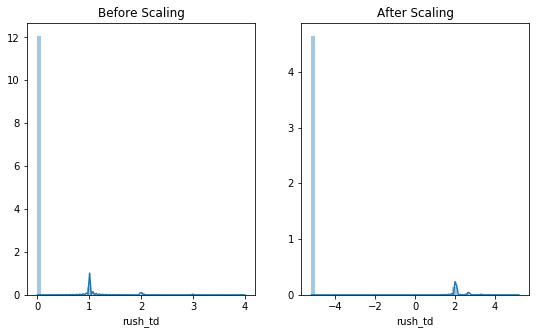

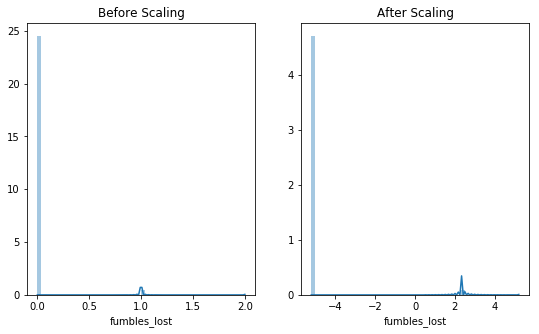

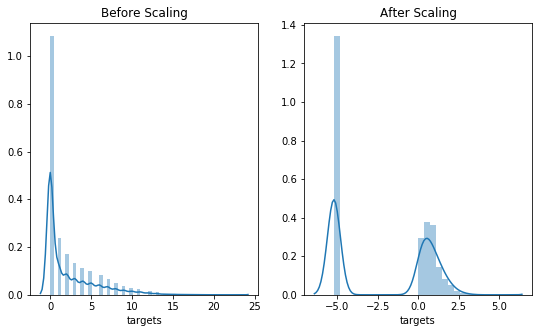

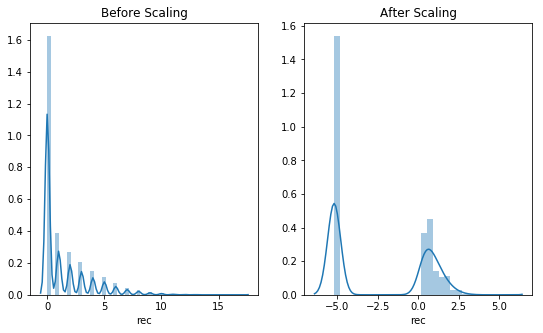

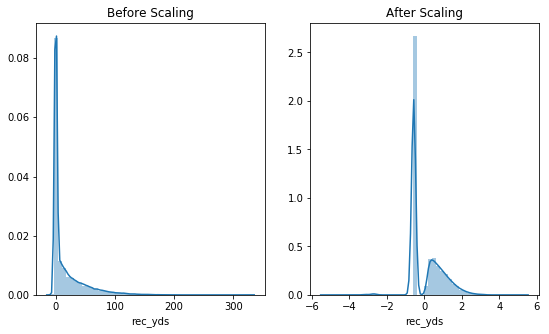

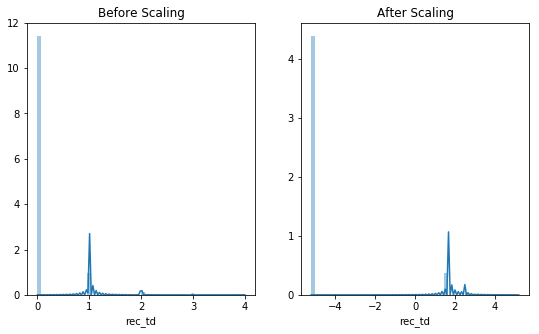

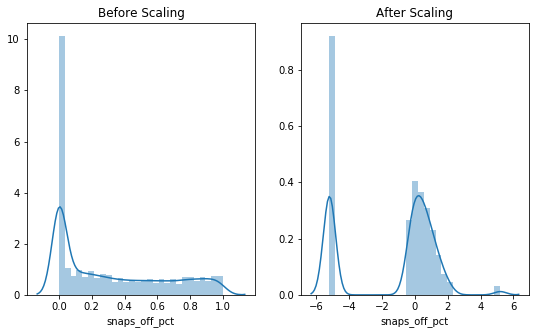

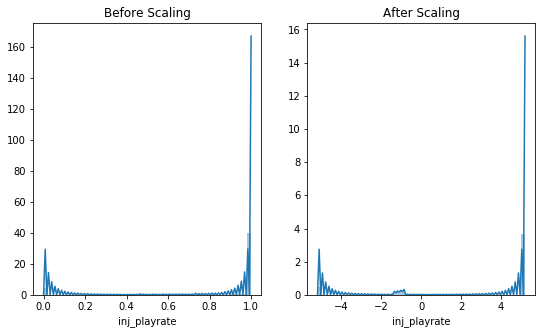

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for col in rbwr_stat_cols:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,5))
    ax1.set_title('Before Scaling')
    ax2.set_title('After Scaling')
    sns.distplot(train_data['raw_df'][col], ax=ax1)
    sns.distplot(scaled_train_data['scaled_df'][col], ax=ax2)
    plt.show()

In [9]:
np.asarray(scaled_train_data['x_batches'][-2:])

array([[[-5.19933758, -0.20978711, -5.19933758, -5.19933758,
         -5.19933758, -5.19933758, -0.57459451, -5.19933758,
         -5.19933758,  5.19933758],
        [-5.19933758, -0.20978711, -5.19933758, -5.19933758,
         -5.19933758, -5.19933758, -0.57459451, -5.19933758,
         -5.19933758,  5.19933758],
        [-5.19933758, -0.20978711, -5.19933758, -5.19933758,
         -5.19933758, -5.19933758, -0.57459451, -5.19933758,
         -5.19933758,  5.19933758],
        [-5.19933758, -0.20978711, -5.19933758, -5.19933758,
         -5.19933758, -5.19933758, -0.57459451, -5.19933758,
         -5.19933758,  5.19933758],
        [-5.19933758, -0.20978711, -5.19933758, -5.19933758,
         -5.19933758, -5.19933758, -0.57459451, -5.19933758,
         -5.19933758,  5.19933758],
        [ 1.10013967,  1.05748501, -5.19933758, -5.19933758,
         -5.19933758, -5.19933758, -0.57459451, -5.19933758,
         -0.26528387,  5.19933758],
        [-5.19933758, -0.20978711, -5.19933758, -5.1

## Define model parameters

In [10]:
x_train = np.asarray(scaled_train_data['x_batches'])
y_train = np.asarray(scaled_train_data['y_batches'])
x_test = np.asarray(scaled_test_data['x_batches'])
y_test = np.asarray(scaled_test_data['y_batches'])

# Input Data
training_data_count = len(x_train)
test_data_count = len(x_test)
n_steps = len(x_train[0])          # timesteps per series
n_input = len(x_train[0][0])       # input parameters per timestep
n_output = len(y_train[0])         # number of output features

# LSTM internal structure
n_hidden = 256  # Features per hidden layer

# Training parameters
learning_rate = 0.001
lambda_loss_amount = 0.015
training_iters = training_data_count * 8  # Loop x times on the training set
batch_size = 100
display_iter = 10000

In [11]:
# Fetch a "batch_size" amount of data from (x|y)_train data
def extract_batch_size(_train, step, batch_size):
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    
    for i in range(batch_size):
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]
        
    return batch_s

In [12]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM from given parameters.
    # Two LSTM cells are stacked
    
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, perm=[1,0,2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input])
    # data should be in shape: (n_steps*batch_size, n_input)
    
    # ReLU activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell neds a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0)
    
    # Two stacked LSTM cells
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden,
                                               forget_bias=1.0,
                                               state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden,
                                               forget_bias=1.0,
                                               state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2],
                                             state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)
    
    # Get last time step's output features for "many-to-one" style structure
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

In [13]:
# Reset graph
tf.reset_default_graph()

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),  # hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_output], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer, and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents overfitting
cost = tf.reduce_sum(tf.square(pred - y)) + l2
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

## Model training

In [14]:
# Keep track of training performance
test_losses = []
train_losses = []

# Launch the graph
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

# Training steps with "batch_size" amount of data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs = extract_batch_size(x_train, step, batch_size)
    batch_ys = extract_batch_size(y_train, step, batch_size)
    
    # Fit trainng using batch data
    _, loss = sess.run(
        [optimizer, cost],
        feed_dict={
            x: batch_xs,
            y: batch_ys
        }
    )
    train_losses.append(loss)
    
    # Evaluate test set occasionally
    if (step*batch_size % display_iter == 0) or (step*batch_size > training_iters):
        
        # Show training/loss in this "if"
        print("Training iter #"+str(step*batch_size) + \
              ":   Batch Loss = " + "{:6f}".format(loss) )
        
        # Evaluate the test set
        loss = sess.run(
            cost, feed_dict={
                x: x_test,
                y: y_test
            }
        )
        test_losses.append(loss)
        print(
            "PERFORMANCE ON TEST SET: " + \
            "Batch Loss = {}".format(loss)
        )
        
    step += 1

print ("Optimization Finished!")

# Accuracy on test data
final_predictions, final_loss = sess.run(
    [pred, cost],
    feed_dict={
        x: x_test,
        y: y_test
    }
)

test_losses.append(final_loss)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss))

Training iter #10000:   Batch Loss = 2426.908447
PERFORMANCE ON TEST SET: Batch Loss = 255867.046875
Training iter #20000:   Batch Loss = 2201.583496
PERFORMANCE ON TEST SET: Batch Loss = 243727.46875
Training iter #30000:   Batch Loss = 2498.253174
PERFORMANCE ON TEST SET: Batch Loss = 246982.484375
Training iter #40000:   Batch Loss = 2603.726562
PERFORMANCE ON TEST SET: Batch Loss = 242196.328125
Training iter #50000:   Batch Loss = 1909.109619
PERFORMANCE ON TEST SET: Batch Loss = 232992.296875
Training iter #60000:   Batch Loss = 2281.698486
PERFORMANCE ON TEST SET: Batch Loss = 233967.796875
Training iter #70000:   Batch Loss = 3097.744141
PERFORMANCE ON TEST SET: Batch Loss = 236470.78125
Training iter #80000:   Batch Loss = 2122.607910
PERFORMANCE ON TEST SET: Batch Loss = 233768.875
Training iter #90000:   Batch Loss = 1652.680176
PERFORMANCE ON TEST SET: Batch Loss = 245954.3125
Training iter #100000:   Batch Loss = 2154.035400
PERFORMANCE ON TEST SET: Batch Loss = 229129.687

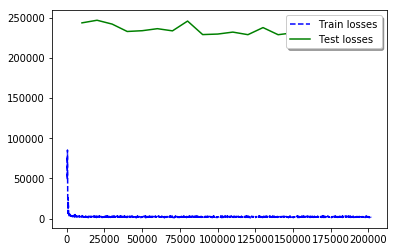

In [15]:
%matplotlib inline

plt.figure()
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis[2:], np.array(train_losses)[2:], "b--", label="Train losses")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis[1:], 
         np.array(test_losses)[1:], 
         "g-", label="Test losses")

plt.legend(loc='upper right', shadow=True)

plt.show()

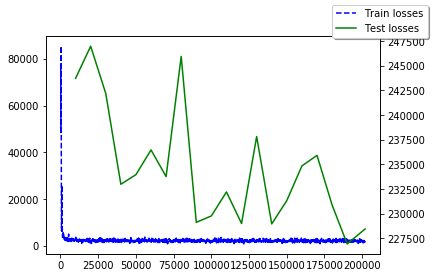

In [16]:
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)

fig, ax1 = plt.subplots()
ax1.plot(indep_train_axis[2:], np.array(train_losses)[2:], "b--", label="Train losses")
ax2 = ax1.twinx()
ax2.plot(indep_test_axis[1:], 
         np.array(test_losses)[1:], 
         "g-", label="Test losses")

fig.legend(loc='upper right', shadow=True)

plt.show()

## Try a different scaler
The above appears to distort the general shapes of the distributions in ways that I'm not pleased with. After applying the scaler to the rush_att column, the difference between getting 0 and 1 carries is greatly exaggerated, to the point that going from 0 to 1 carry makes at least as much difference on the scaled x value as going from 1 to 10 carries. We care more about the difference between 1 and 10 carries, but the cost function would care more about the difference between 0 and 1.

Try a simple min-max scaler instead, just to put all of our input values between 0 and 1.

In [17]:
# Create a min-max scaler and use the training set to parameterize it
mm = preprocessing.MinMaxScaler()
fitted_mm = mm.fit(train_data['raw_df'][rbwr_stat_cols])

# Create scaled datasets
minmax_train_data = make_batches(train_set, scaler=fitted_mm)
minmax_test_data = make_batches(test_set, scaler=fitted_mm)
print(train_data['x_batches'][-1:])
print(minmax_train_data['x_batches'][-1:])

[array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 2.    ,  5.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.07  ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  3.    ,  1.    , 19.    ,
         0.    ,  0.17  ,  0.4545],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.02  ,  1.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.06  ,  1.    ]])]
[array([[0.        , 0.0483871 , 0.        , 0.        , 0.        ,
        0.        , 0.02662722, 0.        , 0.        , 1.        ],
   

/home/welced12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


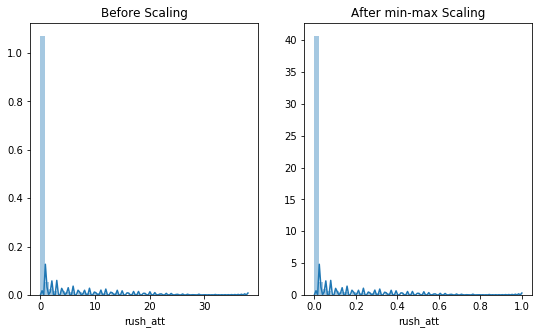

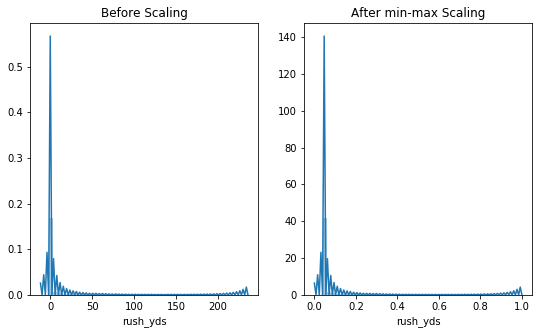

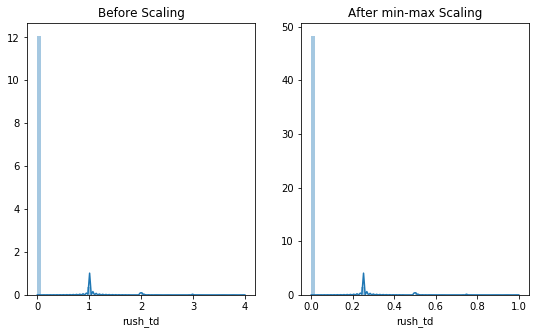

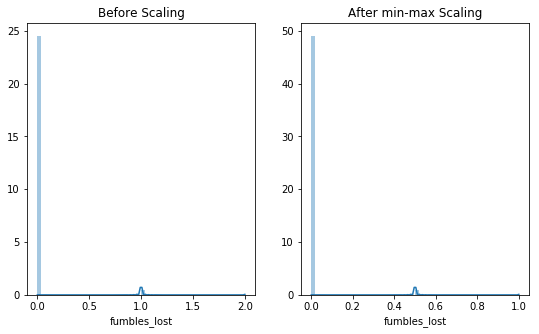

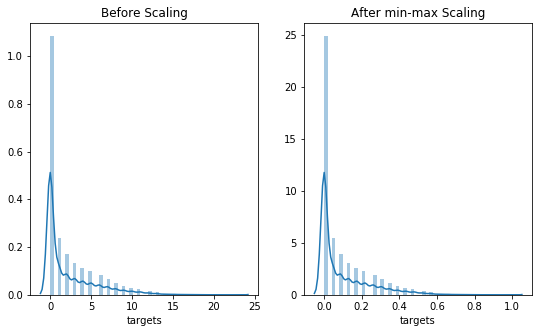

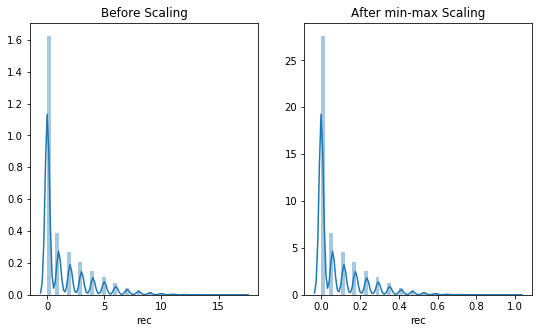

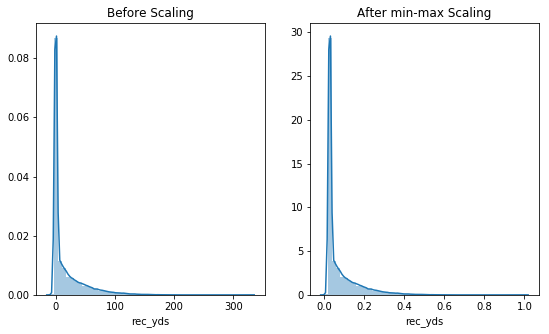

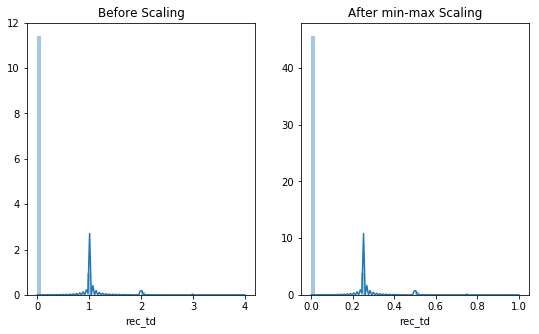

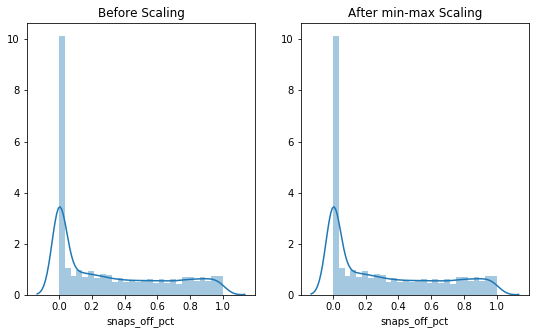

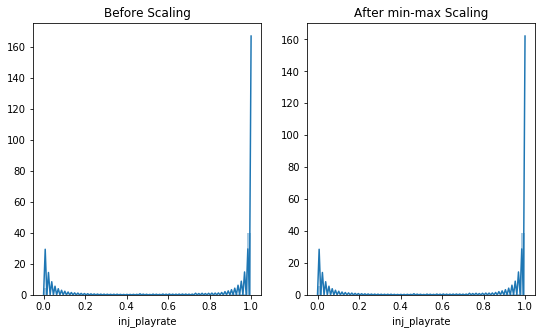

In [18]:
# View effects of scaling
for col in rbwr_stat_cols:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,5))
    ax1.set_title('Before Scaling')
    ax2.set_title('After min-max Scaling')
    sns.distplot(train_data['raw_df'][col], ax=ax1)
    sns.distplot(minmax_train_data['scaled_df'][col], ax=ax2)
    plt.show()

## Train new model with simpler scaler

In [19]:
x_train = np.asarray(minmax_train_data['x_batches'])
y_train = np.asarray(minmax_train_data['y_batches'])
x_test = np.asarray(minmax_test_data['x_batches'])
y_test = np.asarray(minmax_test_data['y_batches'])

In [20]:
# Reset graph
tf.reset_default_graph()

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),  # hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_output], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer, and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents overfitting
cost = tf.reduce_sum(tf.square(pred - y)) + l2
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [21]:
# Keep track of training performance
test_losses = []
train_losses = []

# Launch the graph
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

# Training steps with "batch_size" amount of data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs = extract_batch_size(x_train, step, batch_size)
    batch_ys = extract_batch_size(y_train, step, batch_size)
    
    # Fit trainng using batch data
    _, loss = sess.run(
        [optimizer, cost],
        feed_dict={
            x: batch_xs,
            y: batch_ys
        }
    )
    train_losses.append(loss)
    
    # Evaluate test set occasionally
    if (step*batch_size % display_iter == 0) or (step*batch_size > training_iters):
        
        # Show training/loss in this "if"
        print("Training iter #"+str(step*batch_size) + \
              ":   Batch Loss = " + "{:6f}".format(loss) )
        
        # Evaluate the test set
        loss = sess.run(
            cost, feed_dict={
                x: x_test,
                y: y_test
            }
        )
        test_losses.append(loss)
        print(
            "PERFORMANCE ON TEST SET: " + \
            "Batch Loss = {}".format(loss)
        )
        
    step += 1

print ("Optimization Finished!")

# Accuracy on test data
final_predictions, final_loss = sess.run(
    [pred, cost],
    feed_dict={
        x: x_test,
        y: y_test
    }
)

test_losses.append(final_loss)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss))

/home/welced12/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training iter #10000:   Batch Loss = 93.343536
PERFORMANCE ON TEST SET: Batch Loss = 2244.95361328125
Training iter #20000:   Batch Loss = 74.779381
PERFORMANCE ON TEST SET: Batch Loss = 1631.58740234375
Training iter #30000:   Batch Loss = 83.787140
PERFORMANCE ON TEST SET: Batch Loss = 1428.8006591796875
Training iter #40000:   Batch Loss = 73.493195
PERFORMANCE ON TEST SET: Batch Loss = 1233.6220703125
Training iter #50000:   Batch Loss = 70.194748
PERFORMANCE ON TEST SET: Batch Loss = 1145.7623291015625
Training iter #60000:   Batch Loss = 74.046043
PERFORMANCE ON TEST SET: Batch Loss = 1090.4869384765625
Training iter #70000:   Batch Loss = 74.875732
PERFORMANCE ON TEST SET: Batch Loss = 1045.244140625
Training iter #80000:   Batch Loss = 73.133224
PERFORMANCE ON TEST SET: Batch Loss = 1009.9946899414062
Training iter #90000:   Batch Loss = 64.332306
PERFORMANCE ON TEST SET: Batch Loss = 1005.7412109375
Training iter #100000:   Batch Loss = 71.278557
PERFORMANCE ON TEST SET: Batch

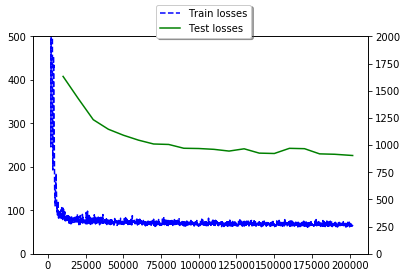

In [22]:
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)

fig, ax1 = plt.subplots()
ax1.set_ylim(0,500)
ax1.plot(indep_train_axis[2:], np.array(train_losses)[2:], "b--", label="Train losses")
ax2 = ax1.twinx()
ax2.set_ylim(0,2000)
ax2.plot(indep_test_axis[1:], 
         np.array(test_losses)[1:], 
         "g-", label="Test losses")

fig.legend(loc='upper center', shadow=True)

plt.show()

## View model predictions
Use the trained model to generate predicted stats.

In [23]:
# Add additional column so that we can use scaler to transform predictions 
# back to real numbers
preds = np.hstack(( final_predictions, final_predictions.sum(1)[...,None] ))

# Transform predictions back to real values
pred_stats = fitted_mm.inverse_transform(preds)
pred_df = pd.DataFrame(pred_stats, columns=rbwr_stat_cols)

# Get context of these predictions from original data set
context_df = pd.concat(
    pd.DataFrame(arr, columns=info_cols) for arr in minmax_test_data['pred_info']
)
context_df = context_df.reset_index().drop(columns=['index'])

pred_df = pd.concat([context_df, pred_df], axis=1)

In [24]:
pred_df[ pred_df['player_a'] == 'D.J. Moore' ]

,player_a,pos,team,season,week,rush_att,rush_yds,rush_td,fumbles_lost,targets,rec,rec_yds,rec_td,snaps_off_pct,inj_playrate
10804,D.J. Moore,WR,CAR,2018,10,1.707620,18.402012,0.151562,0.083522,3.899861,3.991237,52.592453,0.234869,0.613898,1.506357
10805,D.J. Moore,WR,CAR,2018,11,0.856442,12.884647,0.065727,0.030551,3.729923,3.937678,51.010639,0.215034,0.666672,1.446362
10806,D.J. Moore,WR,CAR,2018,12,0.674084,1.424850,0.091517,-0.015298,4.513831,4.524421,55.402908,0.219127,0.685362,1.480183
10807,D.J. Moore,WR,CAR,2018,13,0.703384,0.662737,0.095788,-0.045856,5.412580,4.974797,69.073952,0.296435,0.756780,1.660430
10808,D.J. Moore,WR,CAR,2018,14,1.383887,0.163610,0.094218,-0.022269,6.182320,4.930281,75.274521,0.311565,0.797719,1.781641
10809,D.J. Moore,WR,CAR,2018,15,1.155197,5.230050,0.066424,0.061704,7.097215,4.813011,64.913528,0.421054,0.837199,1.900169
10810,D.J. Moore,WR,CAR,2018,16,0.979122,10.074362,-0.034233,-0.010233,6.219474,4.647268,56.493473,0.287563,0.833749,1.744289
10811,D.J. Moore,WR,CAR,2018,17,0.603648,6.482643,-0.076979,0.048639,6.336345,4.420197,50.983562,0.298796,0.857837,1.740994


In [25]:
test_data['raw_df'][ test_data['raw_df']['player_a'] == 'D.J. Moore' ]

,player_a,pos,team,season,week,rush_att,rush_yds,rush_td,fumbles_lost,targets,rec,rec_yds,rec_td,snaps_off_pct,inj_playrate
9265,D.J. Moore,WR,CAR,2018,1,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0
9266,D.J. Moore,WR,CAR,2018,10,1.0,5.0,0.0,0.0,5.0,4.0,20.0,0.0,0.86,1.0
9267,D.J. Moore,WR,CAR,2018,11,0.0,0.0,0.0,0.0,8.0,7.0,157.0,1.0,0.78,1.0
9268,D.J. Moore,WR,CAR,2018,12,1.0,7.0,0.0,0.0,9.0,8.0,91.0,0.0,0.92,1.0
9269,D.J. Moore,WR,CAR,2018,13,2.0,21.0,0.0,0.0,8.0,4.0,44.0,0.0,0.94,1.0
9270,D.J. Moore,WR,CAR,2018,14,1.0,0.0,0.0,0.0,8.0,5.0,67.0,0.0,0.91,1.0
9271,D.J. Moore,WR,CAR,2018,15,1.0,22.0,0.0,1.0,3.0,2.0,12.0,0.0,0.98,1.0
9272,D.J. Moore,WR,CAR,2018,16,0.0,0.0,0.0,0.0,7.0,2.0,19.0,0.0,0.95,1.0
9273,D.J. Moore,WR,CAR,2018,17,0.0,0.0,0.0,0.0,8.0,4.0,81.0,0.0,0.82,1.0
9274,D.J. Moore,WR,CAR,2018,2,1.0,7.0,0.0,0.0,2.0,1.0,51.0,1.0,0.25,1.0


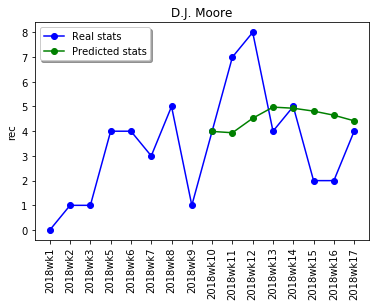

In [26]:
# plot predictions vs. real stats
def plot_preds(name, stat):
    real_stats = test_data['raw_df'][ test_data['raw_df']['player_a'] == name ].sort_values(
        by=['season','week']
    )
    pred_stats = pred_df[ pred_df['player_a'] == name ]
    
    fig, ax1 = plt.subplots()
    real_vals = [
        (i, yr, wk, val) 
        for i, (yr, wk, val) in enumerate(zip(real_stats['season'].values,
                                            real_stats['week'].values,
                                            real_stats[stat].values))
    ]
    pred_vals = [
        (i, yr, wk, val) 
        for i, (yr, wk, val) in enumerate(zip(pred_stats['season'].values,
                                            pred_stats['week'].values,
                                            pred_stats[stat].values))
    ]
    
    # Map all values together
    map_to_x = {'{}wk{}'.format(t[1],t[2]): t[0] for t in real_vals}
    real_x = [map_to_x[ '{}wk{}'.format(t[1],t[2]) ] for t in real_vals ]
    real_y = [t[3] for t in real_vals]
    pred_x = [map_to_x[ '{}wk{}'.format(t[1],t[2]) ] for t in pred_vals ]
    pred_y = [t[3] for t in pred_vals]
    
    plt.xticks(real_x, [ '{}wk{}'.format(t[1],t[2]) for t in real_vals ],
               rotation='vertical')
    ax1.plot(real_x, real_y, 'bo-', label='Real stats')
    ax1.plot(pred_x, pred_y, 'go-', label='Predicted stats')
    
    ax1.set_title(name)
    ax1.set_ylabel(stat)
    ax1.legend(loc='upper left', shadow=True)
    
    plt.show()

plot_preds('D.J. Moore','rec')

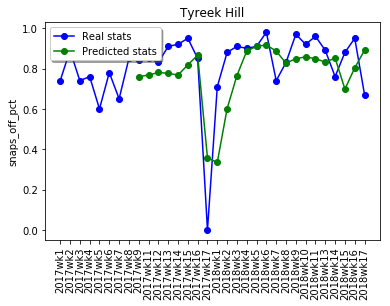

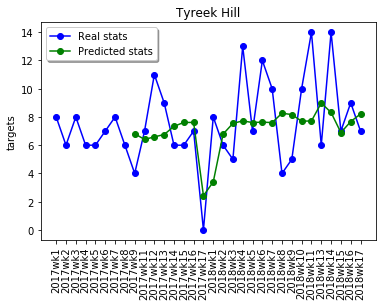

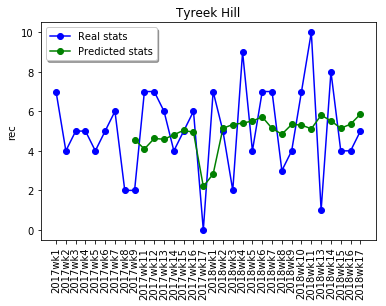

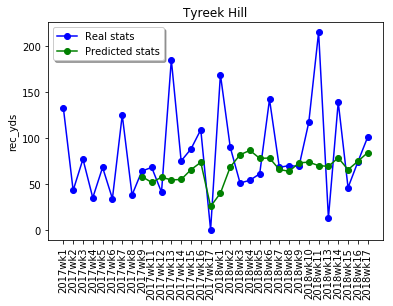

In [27]:
for stat in ['snaps_off_pct','targets','rec','rec_yds']:
    plot_preds('Tyreek Hill',stat)

## Commentary

The model appears to produce reasonable values for stat predictions. I think that the inclusion of injury status in the dataset really helps the model account for otherwise inexplicable shifts week-to-week. 

Further inquiry would be requried to see if this model produces better numbers than some simpler time-series methods.